This file is for data generation using the models (WGAN-GPs), with previous real data visualization, reshaping, training and generation.

The generated data is then analyzed and visualized.

# Import packages & data

In [1]:
!pip install torch_geometric
!pip install hsluv

In [2]:
import pandas as pd
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import shutil
import datetime

import importlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops, degree, erdos_renyi_graph
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.datasets import TUDataset

For Google Colab run:

In [3]:
from google.colab import drive
drive_path = '/content/drive/MyDrive/IRD_Sète/Github_repo/'   # To adjust for your specific directory
drive.mount('/content/drive/')

import sys
sys.path.append(drive_path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
num_nodes = 50
gan = "GraphWGAN_GP3"      # and change below True/False
WGAN_GP1 = False
WGAN_GP2 = False
WGAN_GP3 = True
WGAN_GP4 = False

colony_abr= [-17.97, -38.70]

sub_set = ""
# sub_set = "BRA_ABR_2019_02/"

oiseau = "Dactyl/"
csv_files = glob.glob(drive_path+"Data/*/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
main_path = drive_path + gan+'/'+str(num_nodes)+"nodes/all_features/"+oiseau  # utilisé pour sauvegarder les modèles et les trajectoires générées

For local run:

In [5]:
# num_nodes = 50
# gan = "GraphWGAN_GP3"      # and change below True/False
# WGAN_GP1 = False
# WGAN_GP2 = False
# WGAN_GP3 = True
# WGAN_GP4 = False

# colony_abr= [-17.97, -38.70]

# sub_set = ""
# # sub_set = "BRA_ABR_2019_02/"

# oiseau = "Dactyl/"
# csv_files = glob.glob("Data/*/"+str(num_nodes)+"nodes/"+oiseau+"*.csv")
# main_path = gan+'/'+str(num_nodes)+"nodes/all_features/"+oiseau  # utilisé pour sauvegarder les modèles et les trajectoires générées

### From csv to df

In [6]:
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

columns = ["lat", "lon"]
# "dist_to_nest", "depth"
# dist_bool = True
df_list = [df[columns] for df in df_list]

# print(df_list[0])
print("Nombre de graphes du dataset : "+str(len(df_list)))

Nombre de graphes du dataset : 141


# Data preprocessing

## Graph modeling

This part is not used in the latest WGAN-GP models since the edge_index are defined within the models. However, the input of these models remain graphs, so do not comment it.

#### From vectors to graphs

In [7]:
import to_graph_utils
importlib.reload(to_graph_utils)         # pour recharger les modifications
from to_graph_utils import *
# df_to_graph, tensor_to_graph, df_to_graph_linked

graph_list = [df_to_graph_linked(df) for df in df_list]
edge_index = graph_list[0].edge_index   # le même pour tous les graphes
for i in range(5) :
    print(graph_list[i])


Data(x=[50, 2], edge_index=[2, 194])
Data(x=[50, 2], edge_index=[2, 194])
Data(x=[50, 2], edge_index=[2, 194])
Data(x=[50, 2], edge_index=[2, 194])
Data(x=[50, 2], edge_index=[2, 194])


#### Graph visualization

These edges are for illustration, as they are redefined within each model.

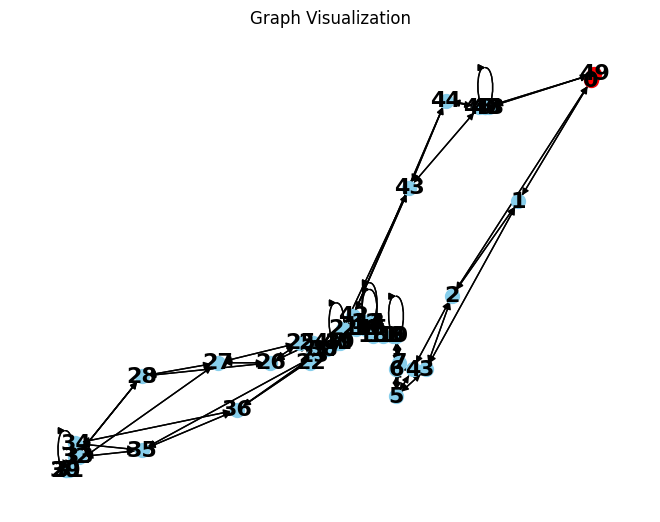

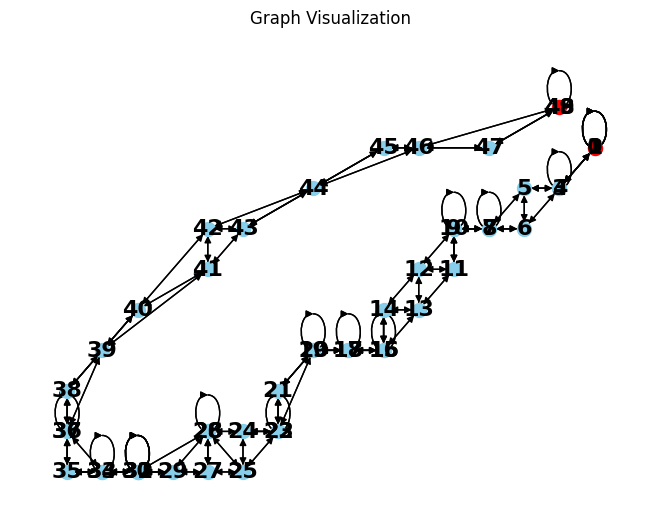

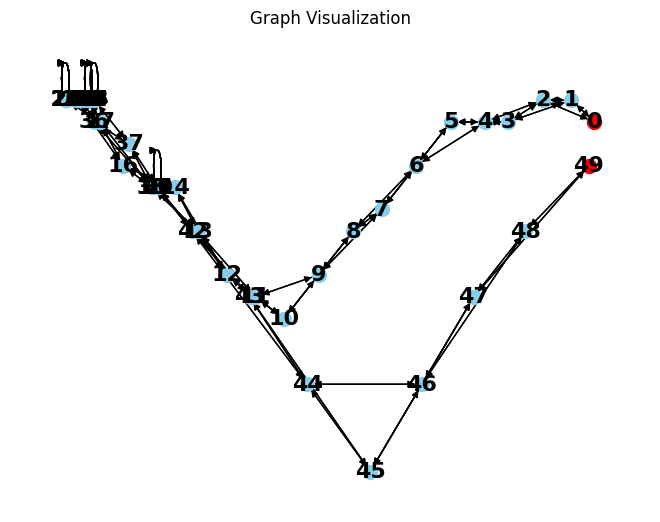

In [8]:
import graph_visualisation
importlib.reload(graph_visualisation)         # pour recharger les modifications
from graph_visualisation import *

for i in range(3) :
    visualize_graph(graph_list[i])

## Data scaling and visualization

### Data scaling

In [9]:
all_features = np.concatenate([graph.x.numpy() for graph in graph_list], axis=0)
print(all_features.shape)
# For data normalization and scaling:
mean = np.mean(all_features, axis=0)
print(mean.shape)
mean = np.array(colony_abr)
print(mean.shape)
std = np.std(all_features, axis=0)

scaled_graph_list = []
for graph in graph_list:
    scaled_features = (graph.x.numpy() - mean) / std
    scaled_features = torch.from_numpy(scaled_features).float()
    scaled_graph_list.append(Data(x=scaled_features, edge_index=graph.edge_index))

dataset = scaled_graph_list

input_size = graph_list[0].num_features
output_size = graph_list[0].num_features
num_nodes = graph_list[0].num_nodes
num_features = graph_list[0].num_features
num_graphs = len(graph_list)

(7050, 2)
(2,)
(2,)


### Visualization after normalization

Plotting all trajectories takes around a minute, so we plot only 8 here but feel free to uncomment"nb = len(data)" for visualization.

Trajectoires réelles


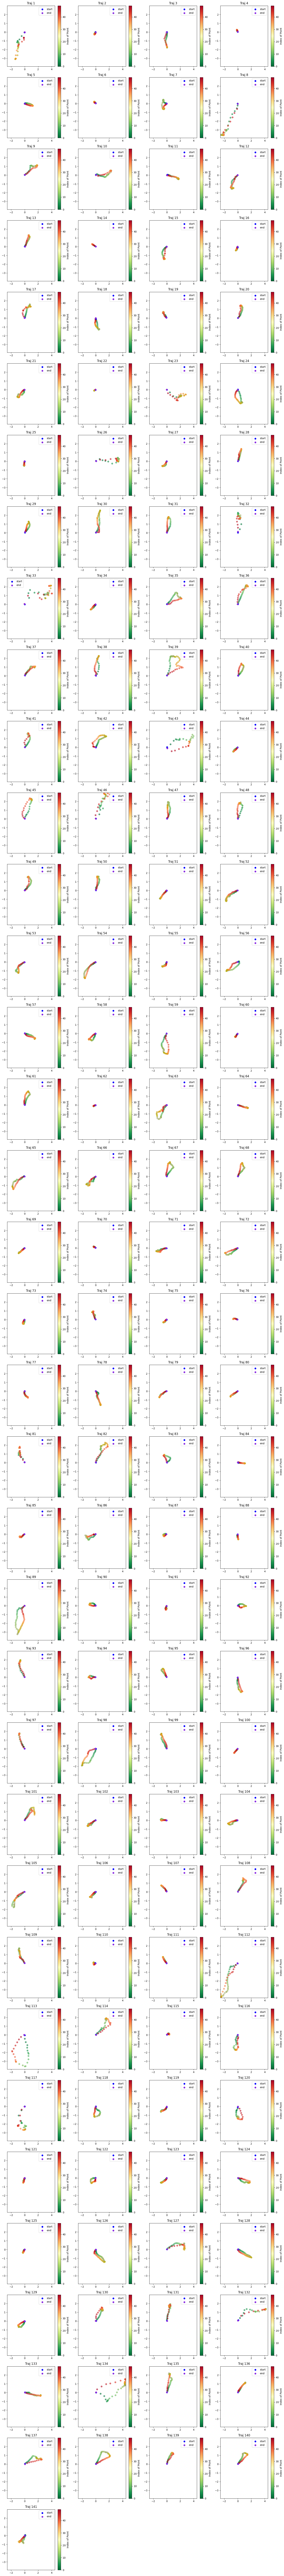

In [10]:
datas = [dataset[i].x.numpy() for i in range(len(dataset))]
# nb = len(datas)
nb = 8
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df[:, 1] for df in datas]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df[:, 0] for df in datas]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# indices = np.arange(len(resized_dfs[0]['lon']))
# norm = plt.Normalize(indices.min(), indices.max())
# cmap = plt.get_cmap('viridis')
# colors = cmap(norm(indices))

import hsluv
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

index = np.arange(num_nodes)
# cmap = plt.cm.get_cmap('RdYlGn_r')  # Red to green colormap
cmap = plt.colormaps['RdYlGn_r']
cmap.set_under('black')
colors = cmap(index / max(index))
hex_colors = [mcolors.to_hex(c) for c in colors]
hsluv_colors = [hsluv.hex_to_hsluv(c) for c in hex_colors]
colors = [hsluv.hsluv_to_hex((h, s, min(l, 70))) for h, s, l in hsluv_colors]

# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        x = datas[i][:, 1]
        y = datas[i][:, 0]

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        scatter = ax.scatter(x, y, c=colors, marker='o', alpha=0.6)
        sm = ScalarMappable(cmap=cmap)
        sm.set_array(index)
        sm.set_clim(0, max(index))

        # Add start and end points
        ax.scatter(x[0], y[0], color='Blue', label='start')
        ax.scatter(x[-1], y[-1], color='BlueViolet', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')

        # Add colorbar to each subplot
        plt.colorbar(sm, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires réelles")
plt.tight_layout()
plt.show()

# Creation of GAN and training

### Import desired GAN

In [11]:
if WGAN_GP1 :
    import GraphWGAN_GP1
elif WGAN_GP2 :
    import GraphWGAN_GP2
elif WGAN_GP3 :
    import GraphWGAN_GP3
elif WGAN_GP4 :
    import GraphWGAN_GP4

In [12]:
if WGAN_GP1 :
    importlib.reload(GraphWGAN_GP1)     # pour recharger les modifications dans le fichier GraphGAN1.py
    from GraphWGAN_GP1 import Discriminator, Generator, GraphGAN
elif WGAN_GP2 :
    importlib.reload(GraphWGAN_GP2)
    from GraphWGAN_GP2 import Discriminator, Generator, GraphGAN
elif WGAN_GP3 :
    importlib.reload(GraphWGAN_GP3)
    from GraphWGAN_GP3 import Discriminator, Generator, GraphGAN
elif WGAN_GP4 :
    importlib.reload(GraphWGAN_GP4)
    from GraphWGAN_GP4 import Discriminator, Generator, GraphGAN

### Generator and Discriminator initialization

In [13]:
if WGAN_GP1 :
    dropout_rate = 0.2
    lambda_gp = 10
    input_dim = 1
    hidden_dim = num_features*2
    d_input_dim = input_size + 0    # +1 pour la dist_to_nest calculée
    generator = Generator(input_dim = input_dim, hidden_dim = hidden_dim, output_dim=input_size, dropout_rate=dropout_rate)
    discriminator = Discriminator(input_dim=d_input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
elif WGAN_GP2 :
    dropout_rate = 0.2
    lambda_gp = 10
    input_dim = 1
    hidden_dim = num_features*2
    d_input_dim = input_size + 0    # +1 pour la dist_to_nest calculée
    generator = Generator(input_dim = input_dim, hidden_dim = hidden_dim, output_dim=input_size, dropout_rate=dropout_rate)
    discriminator = Discriminator(input_dim=d_input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
elif WGAN_GP3 :
    dropout_rate = 0.2
    lambda_gp = 10
    input_dim = 16
    hidden_dim = num_features*2
    d_input_dim = input_size + 0    # +1 pour la dist_to_nest calculée
    generator = Generator(input_dim = input_dim, hidden_dim = hidden_dim, output_dim=input_size, dropout_rate=dropout_rate)
    discriminator = Discriminator(input_dim=d_input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)
elif WGAN_GP4 :
    dropout_rate = 0.2
    lambda_gp = 10
    input_dim = 16
    hidden_dim = num_features*2
    d_input_dim = input_size + 0    # +1 pour la dist_to_nest calculée
    generator = Generator(input_dim = input_dim, hidden_dim = hidden_dim, output_dim=input_size, dropout_rate=dropout_rate)
    discriminator = Discriminator(input_dim=d_input_dim, hidden_dim=hidden_dim, dropout_rate=dropout_rate)

Run from this cell below to train from the weights of the last training

In [14]:
folder_path = main_path+sub_set+'poids_intermediaires/'
if not os.path.exists(folder_path):
    Path(folder_path).mkdir(parents=True, exist_ok=True)
else :
    # Load generator and discriminator weights
    generator.load_state_dict(torch.load(folder_path+'generator_weights.pth'))
    discriminator.load_state_dict(torch.load(folder_path+'discriminator_weights.pth'))


Use this command in a terminal to launch tensorboard for training visualization

In [15]:
# tensorboard --logdir=logs

### GAN initialization

In [16]:
batch_size = 8
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.is_available())

cpu
False


In [18]:
# Use the date for folders with network weights and perfomance
date = datetime.datetime.now().strftime("%d-%m-%Y--%H h %M")
logs_dir = "logs/" + gan +'/'+ date
Path(logs_dir + '/').mkdir(parents=True, exist_ok=True)

if WGAN_GP1 :
    graph_gan = GraphGAN(generator, discriminator, data_loader, device,
                        lr_d=0.0005, lr_g=0.0005, input_dim=input_dim, lambda_gp=lambda_gp,
                        critic_it=1, gene_it=1,
                        logs_dir=logs_dir, lambda_reg=0.0,
                        spectral_type="freq", lambda_rep=0.0, sigma=0.5)
elif WGAN_GP2 :
    graph_gan = GraphGAN(generator, discriminator, data_loader, device,
                        lr_d=0.0005, lr_g=0.0005, input_dim=input_dim, lambda_gp=lambda_gp,
                        critic_it=1, gene_it=1,
                        logs_dir=logs_dir, lambda_reg=0.0,
                        spectral_type="freq", lambda_rep=0.0, sigma=0.5)
elif WGAN_GP3 :
    graph_gan = GraphGAN(generator, discriminator, data_loader, device,
                        lr_d=0.0005, lr_g=0.0005, input_dim=input_dim, lambda_gp=lambda_gp,
                        critic_it=1, gene_it=1,
                        logs_dir=logs_dir, lambda_reg=0.0,
                        spectral_type="freq", lambda_rep=0.0, sigma=0.5)

elif WGAN_GP4 :
    graph_gan = GraphGAN(generator, discriminator, data_loader, device,
                        lr_d=0.00002, lr_g=0.0001, input_dim=input_dim, lambda_gp=lambda_gp,
                        critic_it=1, gene_it=1,
                        logs_dir=logs_dir, lambda_reg=0.0,
                        spectral_type="freq", lambda_rep=0.0, sigma=0.5)

### Save hyperparameters

In [19]:
hyperparameters = {
    "Generator Hyperparameters": {
        "input_dim": generator.input_dim,
        "hidden_dim": generator.hidden_dim,
        "output_dim": generator.output_dim,
        "dropout_rate": generator.dropout_rate
    },
    "Discriminator Hyperparameters": {
        "input_dim": discriminator.input_dim,
        "hidden_dim": discriminator.hidden_dim,
        "dropout_rate": discriminator.dropout_rate
    },
    "GraphGAN Hyperparameters": {
        "lr_d": graph_gan.lr_d,
        "lr_g": graph_gan.lr_g,
        "input_dim": graph_gan.input_dim,
        "lambda_gp": graph_gan.lambda_gp,
        "critic_it": graph_gan.critic_it,
        "gene_it": graph_gan.gene_it,
        "logs_dir": graph_gan.logs_dir,
        "lambda_reg": graph_gan.lambda_reg,
        # "spectral_type": graph_gan.spectral_type,
        "lambda_rep": graph_gan.lambda_rep,
        "sigma": graph_gan.sigma,
        "logs_dir": graph_gan.logs_dir,
        "batch_size": batch_size
    }
}

# Save the hyperparameters to a text file
file_path = logs_dir + "/model_hyperparameters.txt"
with open(file_path, 'w') as file:
    file.write("Model Hyperparameters:\n")
    for model, params in hyperparameters.items():
        file.write(f"{model}:\n")
        for key, value in params.items():
            file.write(f"  {key}: {value}\n")

## Training

In [20]:
num_epochs = 0
# tensorboard --logdir=logs

# # TRAINING
graph_gan.train(num_epochs)

# # Save generator and discriminator weights in higher folder for easier reuse
# torch.save(generator.state_dict(), folder_path+'generator_weights.pth')
# torch.save(discriminator.state_dict(), folder_path+'discriminator_weights.pth')

# Save generator and discriminator weights in the date folder
folder_path_date = folder_path + date + '/'
Path(folder_path_date).mkdir(parents=True, exist_ok=True)
torch.save(generator.state_dict(), folder_path_date+'generator_weights.pth')
torch.save(discriminator.state_dict(), folder_path_date+'discriminator_weights.pth')

# Save the hyperparameters in a text file
file_path = folder_path_date + "model_hyperparameters.txt"
with open(file_path, 'w') as file:
    file.write("Model Hyperparameters:\n")
    for model, params in hyperparameters.items():
        file.write(f"{model}:\n")
        for key, value in params.items():
            file.write(f"  {key}: {value}\n")

Training: 0it [00:00, ?it/s]

Fin du training


# Results: trajectory generation and evaluation

### Generation of fake data

In [21]:
# # Set the generator model to evaluation mode
# folder_path_spe = main_path+sub_set+'poids_intermediaires/'+'12-07-2024--14 h 41/'
# generator.load_state_dict(torch.load(folder_path_spe+'generator_weights.pth'))
generator.eval()

num_graphs_to_generate = len(df_list)
generated_graphs = []
# edge_probability = 0.5


with torch.no_grad():  # Disable gradient calculation
    for _ in range(num_graphs_to_generate):
        if WGAN_GP1 :
            edge_index = edge_indexes(1, num_nodes, 5) # to modify accordingly to file GraphWGAN_GP1 choice
            input_noise = torch.randn(num_nodes, input_dim).to(device)
            generated_output = generator(input_noise, edge_index)
        elif WGAN_GP2:
            edge_index_1 = edge_indexes(1, num_nodes, 1).to(device)
            edge_index_2 = edge_indexes(1, num_nodes, 3).to(device)
            edge_index_3 = edge_indexes(1, num_nodes, 5).to(device)
            edge_index_4 = edge_indexes(1, num_nodes, 7).to(device)
            edge_index_5 = edge_indexes(1, num_nodes, 10).to(device)
            input_noise = torch.randn(num_nodes, input_dim).to(device)
            generated_output = generator(input_noise, edge_index_1, edge_index_2, edge_index_3, edge_index_4, edge_index_5)
        elif WGAN_GP3:
            edge_index_1 = edge_indexes(1, num_nodes, 10).to(device)
            edge_index_2 = edge_indexes(1, num_nodes, 7).to(device)
            edge_index_3 = edge_indexes(1, num_nodes, 5).to(device)
            edge_index_4 = edge_indexes(1, num_nodes, 3).to(device)
            edge_index_5 = edge_indexes(1, num_nodes, 1).to(device)
            input_noise = torch.randn(num_nodes, input_dim).to(device)
            generated_output = generator(input_noise, edge_index_1, edge_index_2, edge_index_3, edge_index_4, edge_index_5)
        elif WGAN_GP4:
            edge_index_1 = edge_indexes(1, num_nodes, 1).to(device)
            edge_index_2 = edge_indexes(1, num_nodes, 3).to(device)
            edge_index_3 = edge_indexes(1, num_nodes, 5).to(device)
            edge_index_4 = edge_indexes(1, num_nodes, 7).to(device)
            edge_index_5 = edge_indexes(1, num_nodes, 10).to(device)
            edge_index_6 = edge_indexes(1, num_nodes, 10).to(device)
            input_noise = torch.randn(num_nodes, input_dim).to(device)
            generated_output = generator(input_noise, edge_index_1, edge_index_2, edge_index_3, edge_index_4, edge_index_5, edge_index_6)
        generated_graphs.append(generated_output)
# print(len(generated_graphs))
print(generated_graphs[0].shape)

torch.Size([50, 2])


## Visualisation

#### Simple (with no background)

Trajectoires générées


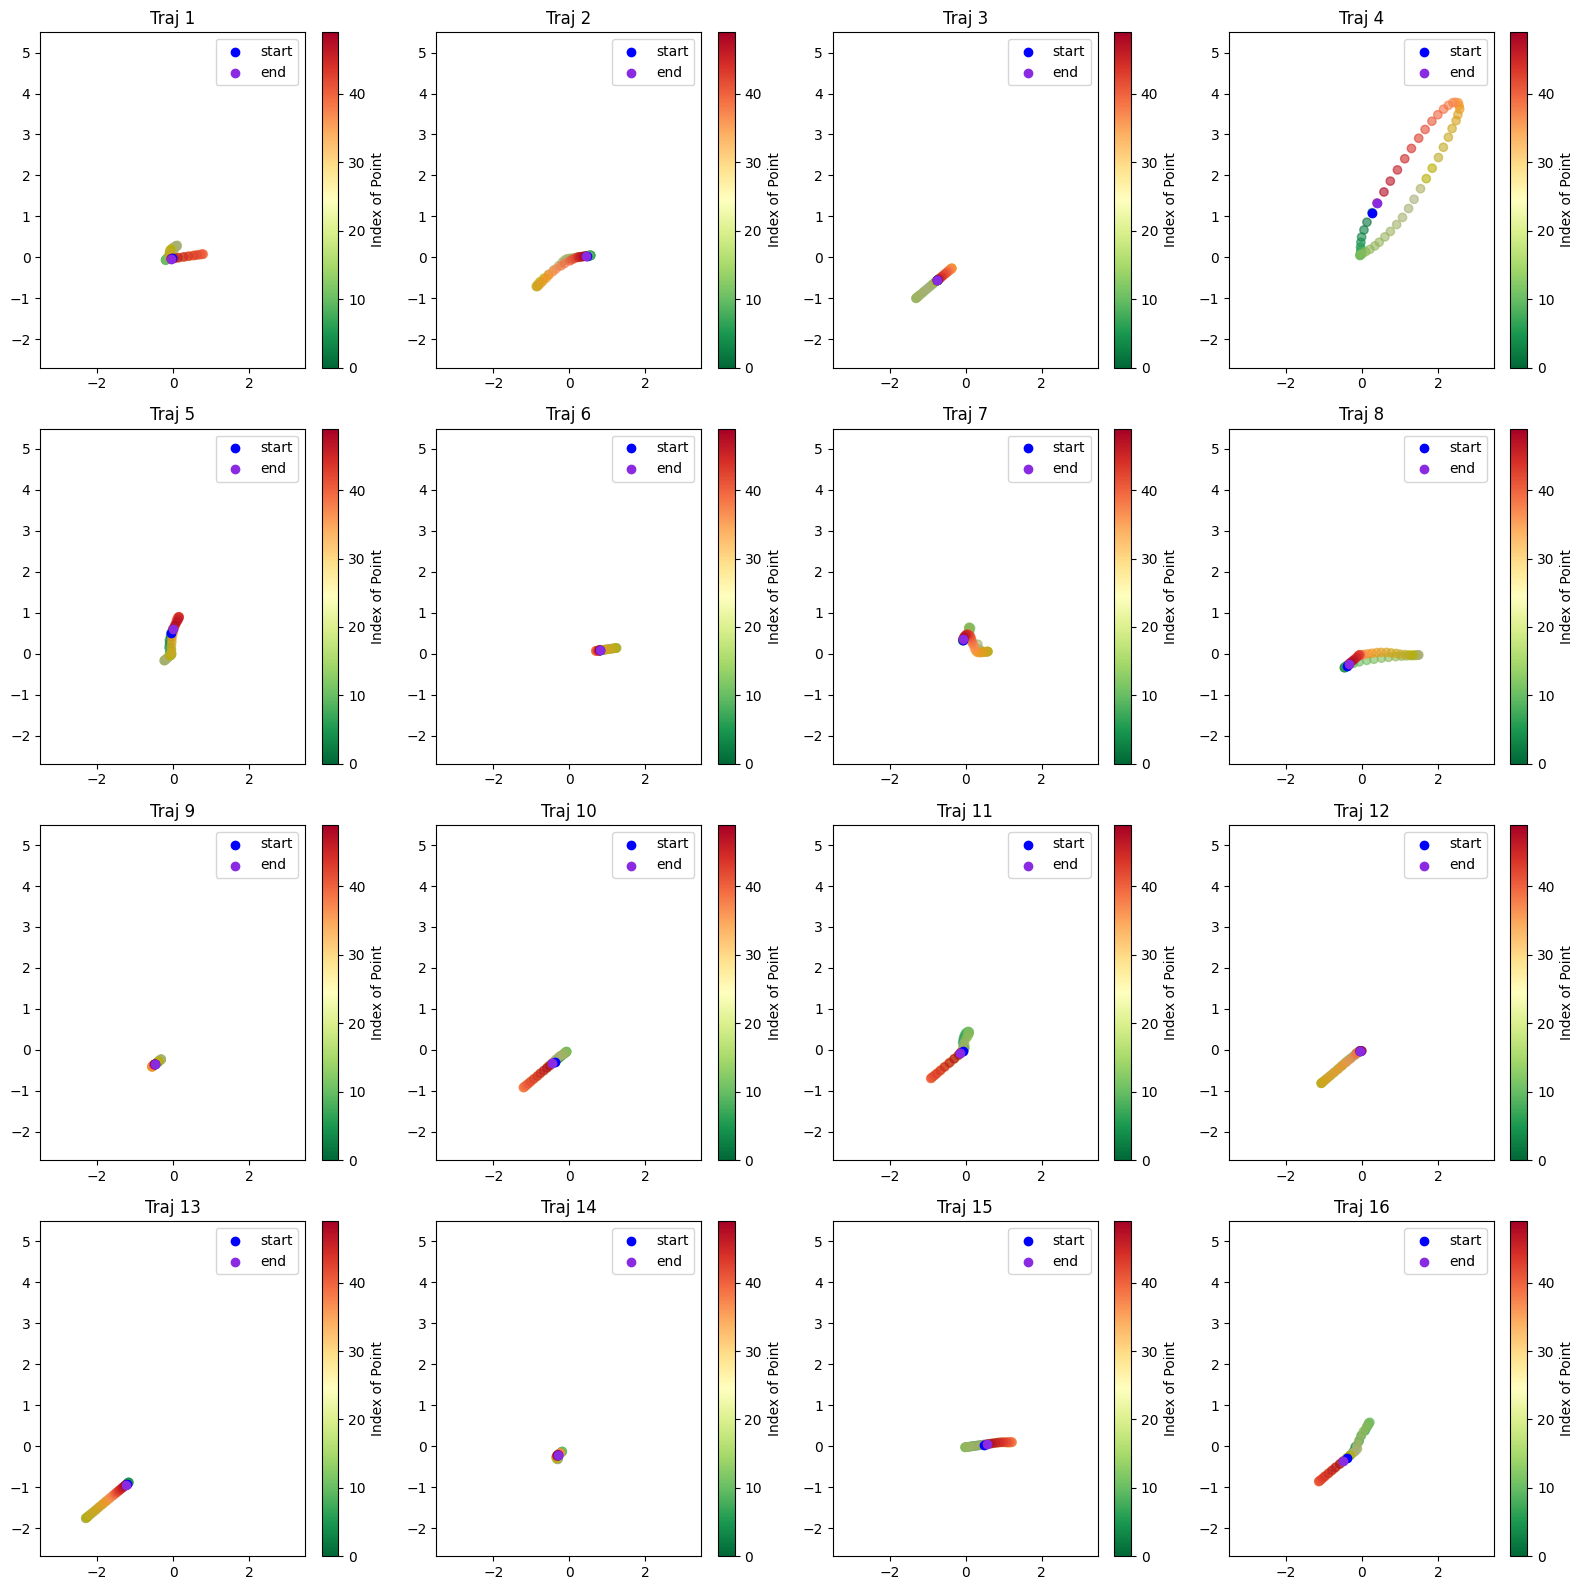

In [22]:
nb = len(generated_graphs)
nb = 16
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df[:, 1].cpu() for df in generated_graphs]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df[:, 0].cpu() for df in generated_graphs]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# indices = np.arange(len(resized_dfs[0]['lon']))
# norm = plt.Normalize(indices.min(), indices.max())
# cmap = plt.get_cmap('viridis')
# colors = cmap(norm(indices))

import hsluv
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

index = np.arange(num_nodes)
# cmap = plt.cm.get_cmap('RdYlGn_r')  # Red to green colormap
cmap = plt.colormaps['RdYlGn_r']
cmap.set_under('black')
colors = cmap(index / max(index))
hex_colors = [mcolors.to_hex(c) for c in colors]
hsluv_colors = [hsluv.hex_to_hsluv(c) for c in hex_colors]
colors = [hsluv.hsluv_to_hex((h, s, min(l, 70))) for h, s, l in hsluv_colors]

# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        x = generated_graphs[i][:, 1].cpu()
        y = generated_graphs[i][:, 0].cpu()

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        # scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        scatter = ax.scatter(x, y, c=colors, marker='o', alpha=0.6)
        sm = ScalarMappable(cmap=cmap)
        sm.set_array(index)
        sm.set_clim(0, max(index))

        # Add start and end points
        ax.scatter(x[0], y[0], color='Blue', label='start')
        ax.scatter(x[-1], y[-1], color='BlueViolet', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')

        # Add colorbar to each subplot
        plt.colorbar(sm, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires générées")
plt.tight_layout()
plt.show()

#### Evaluation (with unscaling and comparison to real data)

In [23]:
import tools
importlib.reload(tools)         # pour recharger les modifications
from tools import *

generated_traj = [generated_graphs[i][:, :2] for i in range(len(generated_graphs))]

for i in range(len(generated_traj)) :
    generated_traj[i] = generated_traj[i].cpu().numpy()
    generated_traj[i][:, :] = generated_traj[i][:, :] - generated_traj[i][0, :]
    generated_traj[i] = generated_traj[i] * std + mean

    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_step_length(generated_traj[i]), axis=1) ), axis=1)
    generated_traj[i] = np.concatenate(( generated_traj[i], np.expand_dims(get_dist_nest(colony_abr, generated_traj[i]), axis=1) ), axis=1)

print(len(df_list))
print(len(generated_traj))
print(generated_traj[0].shape)

df_reals = [df.to_numpy() for df in df_list]
print(df_reals[0].shape)
for i in range(len(df_list)):
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_step_length(df_reals[i]), axis=1) ), axis=1)
    df_reals[i] = np.concatenate(( df_reals[i], np.expand_dims(get_dist_nest(colony_abr, df_reals[i]), axis=1) ), axis=1)

dist_max_gen = np.array([get_max_dist_nest(colony_abr, generated_traj[i]) for i in range(len(generated_traj))])
total_dist_gen = np.array([total_distance(generated_traj[i]) for i in range(len(generated_traj))])
dist_max_real = np.array([get_max_dist_nest(colony_abr, df_list[i].to_numpy()) for i in range(len(df_list))])
total_dist_real = np.array([total_distance(df_list[i].to_numpy()) for i in range(len(df_list))])

all_distances = dist_max_real + dist_max_gen
min_distance = min(min(dist_max_real), min(dist_max_gen))
max_distance = max(max(dist_max_real), max(dist_max_gen))
all_total = total_dist_real + total_dist_gen
min_total = min(min(total_dist_real), min(total_dist_gen))
max_total = max(max(total_dist_real), max(total_dist_gen))


# # Plot for single trajectories
# for i in range(min(3, len(generated_traj))) :

#     dist_nest_column = torch.tensor(get_dist_nest(colony_abr, generated_traj[i]))
#     plt.plot(dist_nest_column)
#     plt.title("Distance to nest for graph "+str(i))
#     plt.show()
#     # print(dist_nest_column)
#     # plt.scatter(generated_traj[i][:,0], generated_traj[i][:,1])
#     # plt.title("Graph "+str(i))
#     # plt.show()

#     step_length_column = torch.tensor(get_step_length(generated_traj[i]))
#     plt.plot(step_length_column)
#     plt.title("Step length for graph "+str(i))
#     plt.show()


141
141
(50, 4)
(50, 2)


Sometimes the generator samples static trajectories, i.e. that don't move from the colony. If so, we replace them by another trajectory, and if there are too many of them the generator is discarded as static trajectories don't exist in the real dataset.

In [24]:
print("Number of trajectories that don't move from the colony:")
for i in range(len(generated_traj)) :
    # # Repérer les valeurs manquantes
    # print("Valeurs manquantes par cellule:\n", np.isnan(traj))
    y_traj = get_trip_sinuosity(generated_traj[i])
    # Nombre de valeurs manquantes par colonne
    if np.isinf(y_traj).sum() > 0 :
        print("\nNumber of missing values for each column:\n", np.isinf(y_traj).sum())
    if np.sum(generated_traj[i][:, 2]) == 0 :
        print(1)
        generated_traj[i] = generated_traj[0]

Number of trajectories that don't move from the colony:


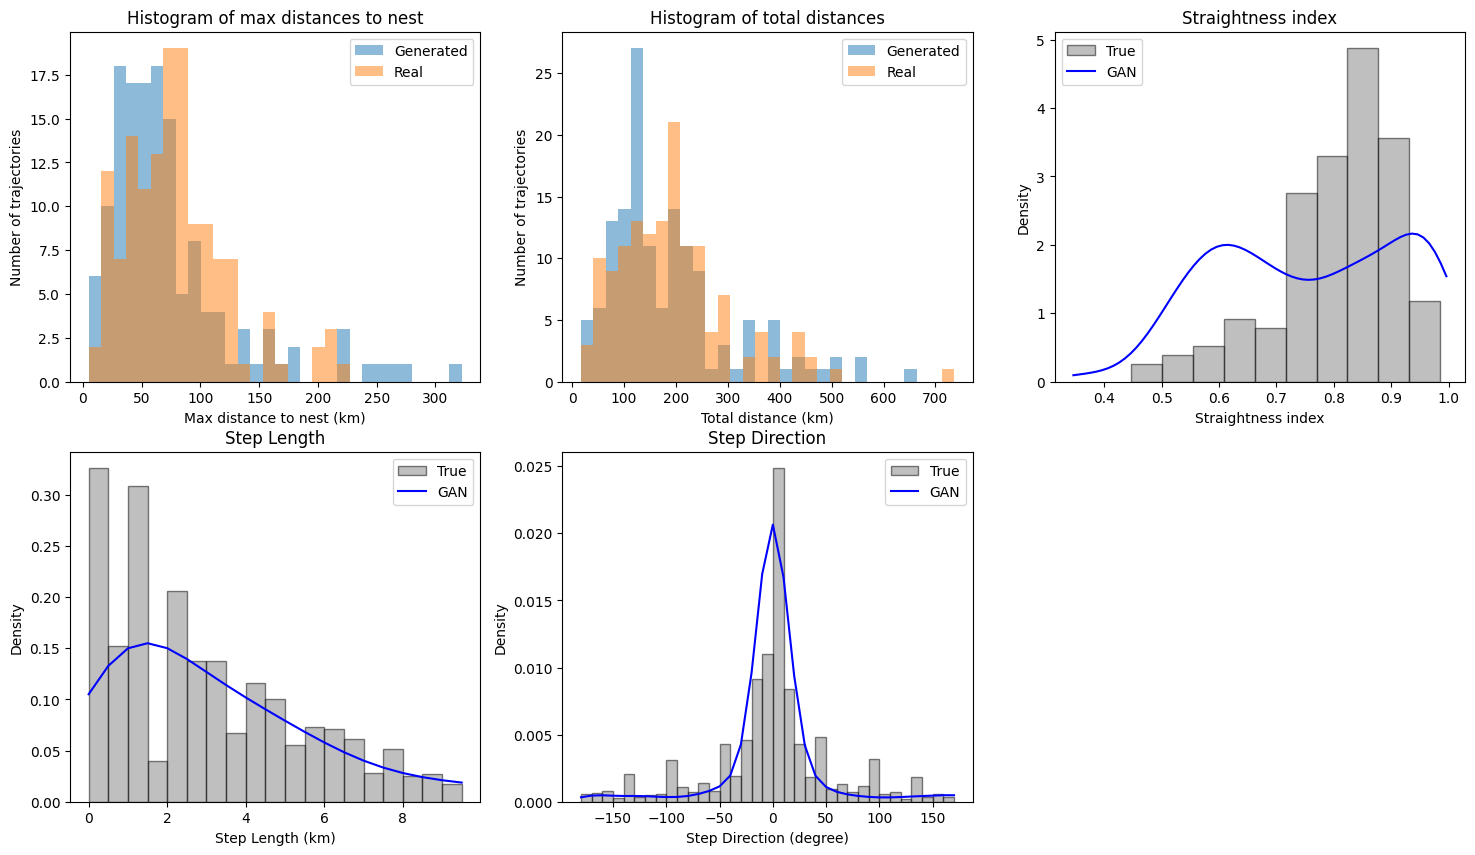

In [25]:
plt.figure(figsize=(18, 10))


# print histogramme des distances max des générées et des réelles
plt.subplot(2, 3, 1)
plt.hist(dist_max_gen, bins=30, alpha=0.5, label='Generated', range=(min_distance, max_distance))
plt.hist(dist_max_real, bins=30, alpha=0.5, label='Real', range=(min_distance, max_distance))
plt.legend(loc='upper right')
plt.xlabel("Max distance to nest (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of max distances to nest")

# print histogramme des distances totales des générées et des réelles
plt.subplot(2, 3, 2)
plt.hist(total_dist_gen, bins=30, alpha=0.5, label='Generated', range=(min_total, max_total))
plt.hist(total_dist_real, bins=30, alpha=0.5, label='Real', range=(min_total, max_total))
plt.legend(loc='upper right')
plt.xlabel("Total distance (km)")
plt.ylabel("Number of trajectories")
plt.title("Histogram of total distances")


# STRAIGHTNESS INDEX
plt.subplot(2, 3, 3)
# Plus la valeur est proche de 1, plus le trajet est rectiligne
y = [get_trip_sinuosity(df) for df in df_reals]
y_1 = [get_trip_sinuosity(traj) for traj in generated_traj]
# y_3 = get_trip_sinuosity(data_fake_3)
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3, bw = 0.3)

x = np.arange(min(min(y),min(y_1)), max(max(y),max(y_1)), 0.01)
plt.hist(y, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.xlabel('Straightness index')
plt.ylabel('Density')
plt.title('Straightness index')
plt.legend()


# STEP LENGTH
plt.subplot(2, 3, 4)
y_1 = np.concatenate([traj[:,2] for traj in generated_traj])
# y_3 = data_fake_3.step_distance/1e3
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(0,10, 0.5)
plt.hist(np.concatenate([df[:,2] for df in df_reals]), color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True, bins = x)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.ylabel('Density')
plt.xlabel('Step Length (km)')
plt.title('Step Length')
plt.legend()


# STEP DIRECTION
plt.subplot(2, 3, 5)
c_fake = np.concatenate( [cap( traj[0:(num_nodes-1), 1], traj[0:(num_nodes-1), 0], traj[1:, 1], traj[1:, 0]) for traj in generated_traj] )
direction_fake = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_fake)]

c_real = np.concatenate( [cap( df[0:(num_nodes-1), 1], df[0:(num_nodes-1), 0], df[1:, 1], df[1:, 0]) for df in df_reals] )
direction_real = [d%360 - 360 if d%360 > 180 else d%360 for d in np.diff(c_real)]

y_1 = direction_fake
# y_3 = data_fake_3.step_direction
dy_1 = kde1d(y_1, bw = 0.3)
# dy_3 = kde1d(y_3.dropna(), bw = 0.3)

x = np.arange(-180,180, 10)
plt.hist(direction_real, bins = x, color = 'gray', label = 'True', alpha = 0.5, edgecolor='k', density = True)
plt.plot(x, dy_1(x), color = 'blue', label = 'GAN')
# plt.plot(x, dy_3(x), color = dicolour['green'], label = 'GAN + Fourier+ step')
plt.ylabel('Density')
plt.xlabel('Step Direction (degree)')
plt.title('Step Direction')
plt.legend()



# Save the hyperparameters to a text file
figure_path = folder_path_date + "stats_descriptives.png"
plt.savefig(figure_path)

#### On a map

In [26]:
df_generated = [pd.DataFrame(generated_graphs[i][:,:2].cpu().numpy(), columns=columns) for i in range(len(generated_graphs))]

for i in range(len(df_generated)):
    df_generated[i].iloc[:, :] = df_generated[i].iloc[:, :] - df_generated[i].iloc[0, :]
    df_generated[i] = df_generated[i]*std + mean

print("Generated trajectories:")
plot_map(df_generated, colony_abr)
print("Real trajectories:")
plot_map(df_list, colony_abr)

Generated trajectories:


Real trajectories:


### Dist to nest

To visualize the distance to nest for each step generated

In [27]:
# nb = len(generated_graphs)
# num_cols = 4
# num_rows = int(np.ceil(nb / num_cols))

# # Calculate the size of each subplot
# subplot_size = 4
# fig_width = num_cols * subplot_size
# fig_height = num_rows * subplot_size

# # Create a figure with subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

# # Plot each trajectory
# for i, ax in enumerate(axs.flatten()):
#     if i < nb:
#         ax.plot(generated_graphs[i][:,2])
#         ax.set_title(f'Dist_to_nest for traj {i+1}')
#     else:
#         ax.axis('off')  # Hide empty subplots